# <center> <font style="color:rgb(100,109,254)"> Shape Detection Application pt 2 (On GUI & Web cam )   </font> </center>

In this notebook we are going to do shape detection on a GUI and also on a web cam feed where we are gonna detect shapes live as we draw on paper.

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## <font style="color:rgb(134,19,348)">  Loading All shapes and saving their contours:  </font>
The first step is to load all shapes and save their contours.

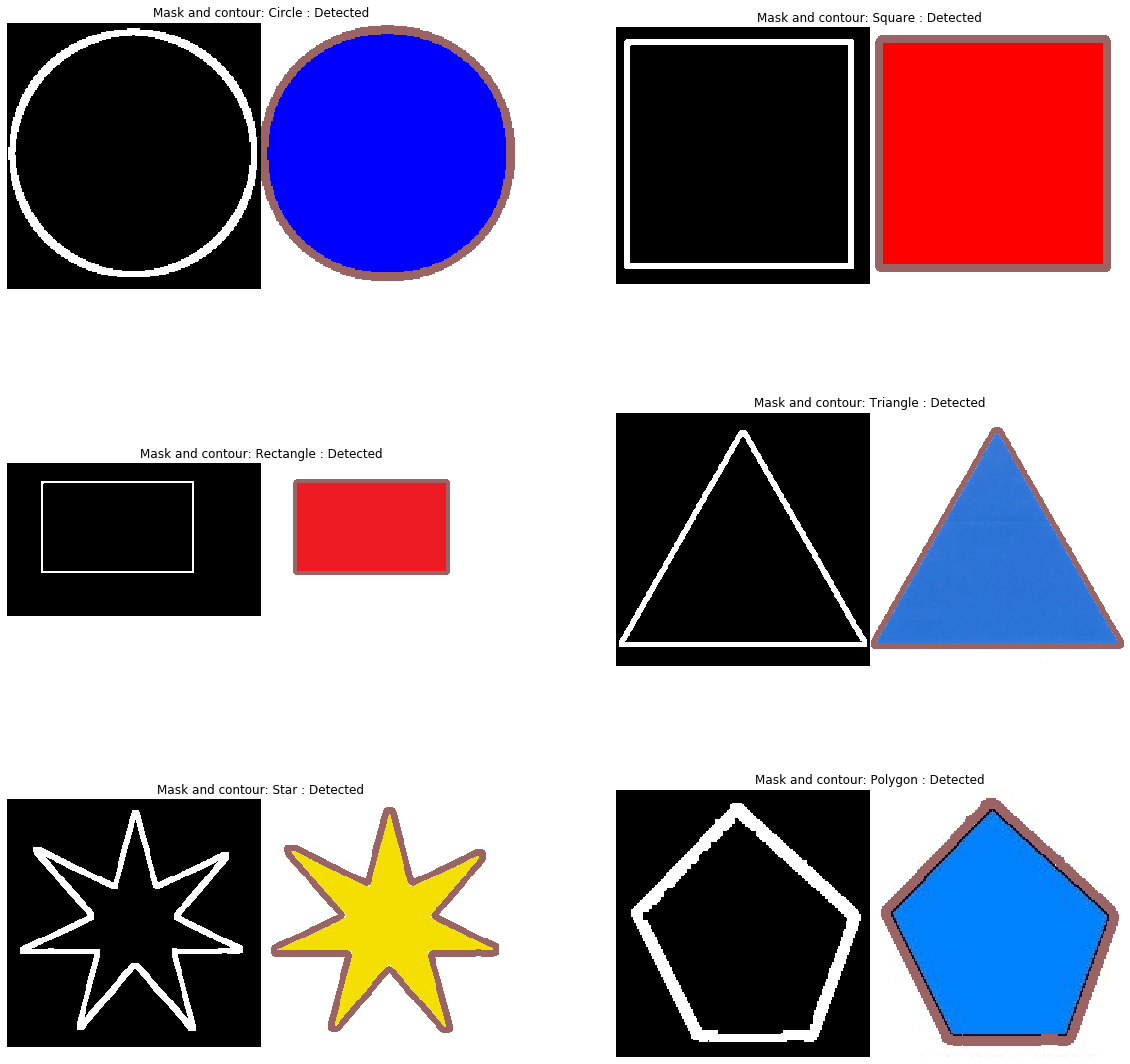

In [38]:
# Read all shape images from memory
circle =    cv2.imread(r'media/M12/shapeimages/circle.png',1)
square =    cv2.imread(r'media/M12/shapeimages/square.png',1)
rectangle = cv2.imread(r'media/M12/shapeimages/rect1.jpeg',1)
triangle =  cv2.imread(r'media/M12/shapeimages/triangle.jpg',1)
star =      cv2.imread(r'media/M12/shapeimages/star.jpg',1)
polygon =   cv2.imread(r'media/M12/shapeimages/polygon.jpg',1)

# Save all shapes in a list
allshapes = [circle, square, rectangle  ,triangle ,star, polygon]

# Save the names of all shapes in the same order.
shapenames= ['Circle','Square', 'Rectangle', 'Triangle', 'Star', 'Polygon']

# create a list for storing contours of each shape
allcontours=[]

# no of rows for plotting (divided by 2 cause we are using 2 columns)
rows = np.ceil(len(allshapes)/2)

# set figsize
plt.figure(figsize=[20,20])

# Now loop over all shapes
for index,shape in enumerate(allshapes):
    
    # perform edge detection
    mask = cv2.Canny(shape,100,300)
    
    # dilate the mask so there are no gaps in the main contour
    mask = cv2.dilate(mask,None,iterations = 2)
    
    # find contours
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Make sure you detected a contour
    if contours:
        
        # state  = detected if you successfully detect a contour and vice versa.
        state = 'Detected'
        
        # Make sure you're extracting a single contour and the maximum one from the image
        c = max(contours, key = cv2.contourArea)

        # draw the contour over the shape (just for visualization)
        cv2.drawContours(shape, [c], 0, (100,100,155), 5)

        # Append the contour in the contour list.
        allcontours.append(c)
    
    else:
        state = 'Not Detected'
    
    # make the mask 3 channeled
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Stack mask and contour together
    stacked = np.hstack((mask,shape))
    
    # draw each contour with masks and their names.
    plt.subplot(rows,2,index+1);plt.imshow(stacked[:,:,::-1]);
    plt.title("Mask and contour: {} : {}".format(shapenames[index],state));plt.axis('off')        

## <font style="color:rgb(134,19,348)"> GUI Drawing Application   </font>
Now what we want to do in this notebook is to draw shapes on a GUI and then detect those shapes. But before we can do that we need to see how we can draw on an image with a mouse. 

The process is fairly simple as the mouse moves around the image, the x,y coordinates of the mouse changes so you just need to draw a line between every two points. One thing we can do is to draw only when the mouse is pressed, so we can use a variable like `drawing` which is True when the mouse is pressed and false when its not so we can toggle between drawing and not drawing.

Lets do this now

In [42]:
# This is our toggle variable , it will be false initially
drawing= False

# creating a named window to attach the mouse callback function.
cv2.namedWindow('image')


# Initilizing the x1,y1 and x2,y2 variables, these will be used to draw the line.
# x1 is None whenever there is no previous x1,y1 points which is true initially.
x1 =None
x2 =0
y1 =0
y2=0


# This function toggles drawing variable to True or False depending upon if the mouse is pressed or not
# It also stores the mouse's coordinates in x2,y2 variables as the mouse moves.
def draw_line(event,x,y,flags,param):
    global  x2, y2,drawing

    if event == cv2.EVENT_MOUSEMOVE:
        x2 = x
        y2 = y       

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

# set some custom width and height
width = 1000
height = 600

# create a black image.
img = np.zeros((height,width,3), np.uint8)

# Attach the window and the function to the mouse call back funtion
cv2.setMouseCallback('image',draw_line)

while True:
    
    # Only draw if drawing is true
    if drawing:
        
        # x1 is not None means we have some previous x1,y1 points which we can use to draw on the image.
        if x1 is not None:                  
            img = cv2.line(img, (x1,y1),(x2,y2), [255,255,255], 5)

            # When we are done drawing the line then the x2,y2 becomes x1,y1 for the next line.
            x1= x2
            y1 = y2
            
        else:
            # If there was no x1,y1 available (which means either the mouse was pressed up or this is the first run of the 
            # program) then we want to initilize them as x2,y2
            x1,y1 = x2,y2
   
    else:
        # x1 is made None if the mouse is up.
        x1 = None

    cv2.imshow('image',img)

    # If the user presses `c` then clear the image.
    k= cv2.waitKey(1)
    if k  == ord('c'):
        img = np.zeros((height,width,3), np.uint8)

    elif k  == 27:
        break
                
cv2.destroyAllWindows()

## <font style="color:rgb(134,19,348)"> Shape Predict Function   </font>
Now this is the same function as in the previous notebook. 

In [43]:
def shape_detector(test_image = None, display = True, thresh = 0.3):
      
        # if the user has not specified any image then open up a file selector so that he can select a file.
        if test_image is None:
            Tk().withdraw() 
            filename = askopenfilename() 
            test_image = cv2.imread(filename)
            
        original = test_image.copy()
        
        # extract the edge mask
        mask = cv2.Canny(test_image,100,300)

        # dilate the mask so there are no gaps in the main contour (comment this line to see the gaps)
        mask = cv2.dilate(mask,None,iterations = 1)

        # detect contours
        contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            for test_contour in contours:

                # get a bounding box around each contour and draw it.
                x,y,w,h = cv2.boundingRect(test_contour)
                cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,255,0),3)

                scores=[]

                # Now for each shape go over all saved contours and save the matchshape score
                for cnt in allcontours:
                    score = cv2.matchShapes(test_contour,cnt,1,0.0)
                    scores.append(score)

                # Grab the index of lowest scoring contour
                pos = np.argmin(np.array(scores))

                # Also grab the minimum score.
                finalscore = min(scores)

                # Make sure the lowest score is below some threshold so we can also label unkown shapes
                if finalscore < thresh:

                    # set label of the detected shape using the index we got previously 
                    label = shapenames[pos]

                else:
                    label = 'Unknown Shape'


                cv2.putText(test_image, label, (x,y+h+16), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (100,55,50), 2, cv2.LINE_AA)
        else: 
            return None
        
        # if display is true then plot the image.
        if display:
            plt.figure(figsize=[15,15])
            plt.subplot(1,2,1);plt.imshow(original[:,:,::-1]);plt.title("Original Image");plt.axis('off')
            plt.subplot(1,2,2);plt.imshow(test_image[:,:,::-1]);plt.title("Shape Detection");plt.axis('off');
            
        else:
            return test_image

## <font style="color:rgb(134,19,348)">  Shape prediction on GUI  </font>
Now lets make the final GUI Application in which we can press `p` to predict on our drawing, we will draw on the image named `img_draw` and predict on the image named `img` 

In [ ]:
# This is our toggle variable , it will be false initially
drawing= False

# creating a named window to attach the mouse callback function.
cv2.namedWindow('image')


# Initilizing the x1,y1 and x2,y2 variables, these will be used to draw the line.
# x1 is None whenever there is no previous x1,y1 points which is true initially.
x1 =None
x2 =0
y1 =0
y2=0



# This function toggles drawing variable to True or False depending upon if the mouse is pressed or not
# It also stores the mouse's coordinates in x2,y2 variables as the mouse moves.
def draw_line(event,x,y,flags,param):
    global x1, x2, y2,drawing

    if event == cv2.EVENT_MOUSEMOVE:
        x2= x
        y2= y       

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

# set some custom width and height
width = 1000
height = 600

# create a black image, predictions will be drawn on this image
img_draw = np.zeros((height,width,3), np.uint8)

# This image is used to predict
img = np.zeros((height,width,3), np.uint8)


# Attach the window and the function to the mouse call back funtion
cv2.setMouseCallback('image',draw_line)

while True:
    
    # Only draw if drawing is true
    if drawing:
        
        # x1 is not None means we have some previous x1,y1 points which we can use to draw on the image.
        if x1 is not None:                  
            img = cv2.line(img, (x1,y1),(x2,y2), [255,255,255], 5)
            img_draw = cv2.line(img, (x1,y1),(x2,y2), [255,255,255], 5)


            # When we are done drawing the line then the x2,y2 becomes x1,y1 for the next line.
            x1= x2
            y1 = y2
            
        else:
            # If there was no x1,y1 available (which means either the mouse was pressed up or this is the first run of the 
            # program) then we want to initilize them as x2,y2
            x1,y1 = x2,y2
   
    else:
        # x1 is made None if the mouse is up.
        x1 = None

    cv2.imshow('image',img_draw)

    # If the user presses `c` then clear the image.
    k= cv2.waitKey(1)
    if k  == ord('c'):
        img = np.zeros((height,width,3), np.uint8)
        img_draw = np.zeros((height,width,3), np.uint8)

    # If p is pressed then you predict on the image.    
    elif k  == ord('p'):
       img_draw = shape_detector(img.copy(),display = False)  

    elif k  == 27:
        break
                
cv2.destroyAllWindows()

**Tip:** So one way to really increase the accuracy of your system is to instead of storing a single image shape contour, you can store multiple contour for different varieties of each shape, so you can detect the same shape with different variations. Now in test time you can make the threshold more strict.

## <font style="color:rgb(134,19,348)"> Shape detection On paper   </font>
Its really easy perform this shape detection with your web cam feed. You can use the same function and pass in each frame of the feed to the shape detection function and display the results.

In [46]:
cam = cv2.VideoCapture(2,cv2.CAP_DSHOW)
cam.set(3,1280)
cam.set(4,720)

cv2.namedWindow('img', cv2.WINDOW_NORMAL)

while (True):
    
      ret ,frame = cam.read()   
      if not ret:
            break

      # Apply the detection on each frame and display it.
      detected_frame = shape_detector(frame,display = False)
      
      # show the detected frame if a contour was detected otherwise show the normal frame.
      if detected_frame is not None:
         cv2.imshow("img",detected_frame)  
      else:
         cv2.imshow("img",frame)  
    
      k= cv2.waitKey(1)
      if k  == 27:
          break
        
cam.release()
cv2.destroyAllWindows()    

###  <font style="color:rgb(34,169,134)"> Assignment: Number Classifier & Detector on GUI & Paper</font>
So now make your previous number classifier work with GUI and Web cam feed on paper.

In [8]:
### ADD CODE HERE 

